# Machine Learning Interpretability in Lapse Prediction for Non-Life Insurance Premium

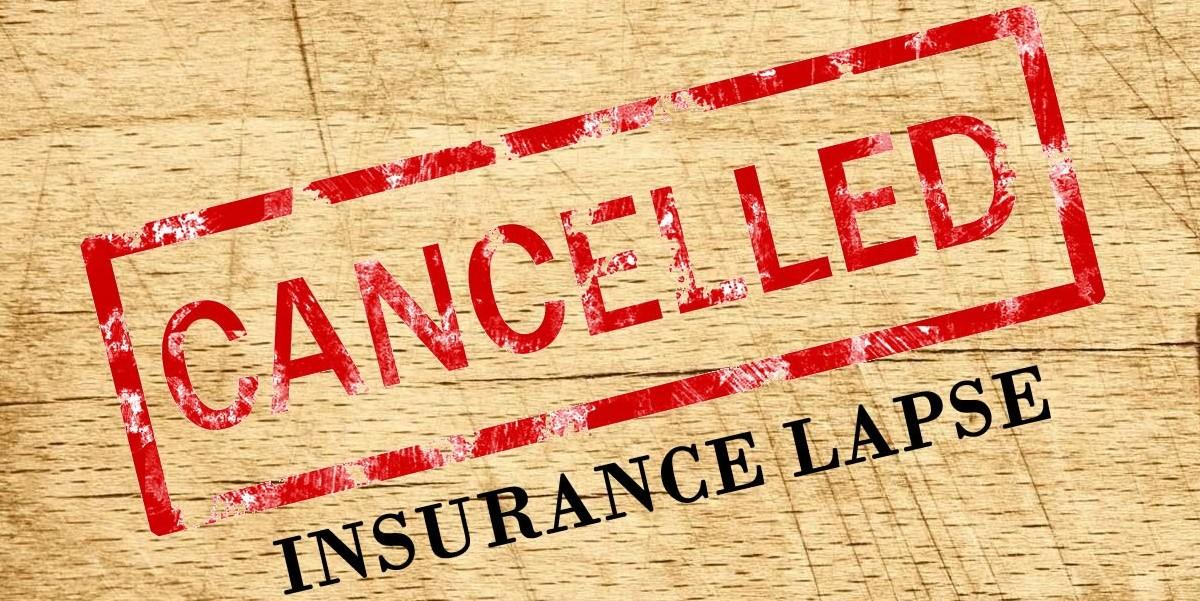

# Prepare Workspace

In [1]:
# to handle datasets
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# for statistics
import statistics as st 
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('eudirectlapse.csv')

# Data set Overview

In [3]:
# Dimensions of data set
print(df.shape)

(23060, 19)


In [4]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23060 entries, 0 to 23059
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lapse                 23060 non-null  int64  
 1   polholder_age         23060 non-null  int64  
 2   polholder_BMCevol     23060 non-null  object 
 3   polholder_diffdriver  23060 non-null  object 
 4   polholder_gender      23060 non-null  object 
 5   polholder_job         23060 non-null  object 
 6   policy_age            23060 non-null  int64  
 7   policy_caruse         23060 non-null  object 
 8   policy_nbcontract     23060 non-null  int64  
 9   prem_final            23060 non-null  float64
 10  prem_freqperyear      23060 non-null  object 
 11  prem_last             23060 non-null  float64
 12  prem_market           23060 non-null  float64
 13  prem_pure             23060 non-null  float64
 14  vehicl_age            23060 non-null  int64  
 15  vehicl_agepurchase 

In [5]:
# Take a peek at the first rows of the data
df.head()

,lapse,polholder_age,polholder_BMCevol,polholder_diffdriver,polholder_gender,polholder_job,policy_age,policy_caruse,policy_nbcontract,prem_final,prem_freqperyear,prem_last,prem_market,prem_pure,vehicl_age,vehicl_agepurchase,vehicl_garage,vehicl_powerkw,vehicl_region
0,0,38,stable,only partner,Male,normal,1,private or freelance work,1,232.46,4 per year,232.47,221.56,243.59,9,8,private garage,225 kW,Reg7
1,1,35,stable,same,Male,normal,1,private or freelance work,1,208.53,4 per year,208.54,247.56,208.54,15,7,private garage,100 kW,Reg4
2,1,29,stable,same,Male,normal,0,private or freelance work,1,277.34,1 per year,277.35,293.32,277.35,14,6,underground garage,100 kW,Reg7
3,0,33,down,same,Female,medical,2,private or freelance work,1,239.51,4 per year,244.40,310.91,219.95,17,10,street,75 kW,Reg5
4,0,50,stable,same,Male,normal,8,unknown,1,554.54,4 per year,554.55,365.46,519.50,16,8,street,75 kW,Reg14


# Data Cleaning

### Delete single column values

In [6]:
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

[]
(23060, 19)


### Delete duplicate rows

In [7]:
# drop duplicate rows
df.drop_duplicates(inplace=True)
print(df.shape)

(23060, 19)


### Handling Missing Values

In [8]:
# Check missing values both to numeric features and categorical features 
missing = df.isnull().sum()/df.shape[0]*100
missing

lapse                   0.0
polholder_age           0.0
polholder_BMCevol       0.0
polholder_diffdriver    0.0
polholder_gender        0.0
polholder_job           0.0
policy_age              0.0
policy_caruse           0.0
policy_nbcontract       0.0
prem_final              0.0
prem_freqperyear        0.0
prem_last               0.0
prem_market             0.0
prem_pure               0.0
vehicl_age              0.0
vehicl_agepurchase      0.0
vehicl_garage           0.0
vehicl_powerkw          0.0
vehicl_region           0.0
dtype: float64

In [9]:
# Numerical format transformation of feature prem_freqperyear
df_1 = df.copy()
df_1['prem_freqperyear'] = df_1['prem_freqperyear'].str.extract('(\d+)') # extract numerical part
df_1['prem_freqperyear'] = df_1['prem_freqperyear'].astype('float') # format variale as numerical

# Summary Statistics

In [10]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df_1.columns if df_1[var].dtype=='object']
df_1[obj_cols].describe().T

,count,unique,top,freq
polholder_BMCevol,23060,3,stable,12036
polholder_diffdriver,23060,7,same,11155
polholder_gender,23060,2,Male,14721
polholder_job,23060,2,normal,13578
policy_caruse,23060,3,private or freelance work,19567
vehicl_garage,23060,8,private garage,8863
vehicl_powerkw,23060,11,75 kW,10339
vehicl_region,23060,14,Reg4,4325


In [11]:
# Summarize attribute distributions for data type of variables
no_obj_cols = [var for var in df_1.columns if df_1[var].dtype!='object']
df_1[no_obj_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
lapse,23060.0,0.128101,0.334209,0.00,0.0000,0.000,0.0000,1.00
polholder_age,23060.0,43.045490,12.352291,19.00,35.0000,41.000,49.0000,85.00
policy_age,23060.0,2.443452,3.100771,0.00,0.0000,1.000,4.0000,17.00
policy_nbcontract,23060.0,1.305637,0.788647,1.00,1.0000,1.000,1.0000,15.00
prem_final,23060.0,374.123791,212.899174,46.55,232.8375,312.250,448.3700,2948.05
prem_freqperyear,23060.0,2.967389,3.172994,1.00,1.0000,1.000,4.0000,12.00
prem_last,23060.0,380.508774,227.937859,46.56,232.6300,311.005,449.6025,3362.07
prem_market,23060.0,373.528631,201.915809,50.11,245.1500,316.830,434.4525,2416.84
prem_pure,23060.0,355.882315,197.138010,45.55,227.1000,301.445,423.5625,2716.08
vehicl_age,23060.0,13.060624,3.590088,0.00,11.0000,13.000,16.0000,18.00


In [12]:
# Split data set between target variable and features
X_full = df_1.copy()
y = X_full.lapse
X_full.drop(['lapse'], axis=1, inplace=True)

# Target Variable Analysis

In [13]:
# Summarize the class distribution 
count = pd.crosstab(index = y, columns="count")
percentage = pd.crosstab(index = y, columns="frequency")/pd.crosstab(index = y, columns="frequency").sum()
pd.concat([count, percentage], axis=1)

col_0,count,frequency
lapse,,
0,20106,0.871899
1,2954,0.128101


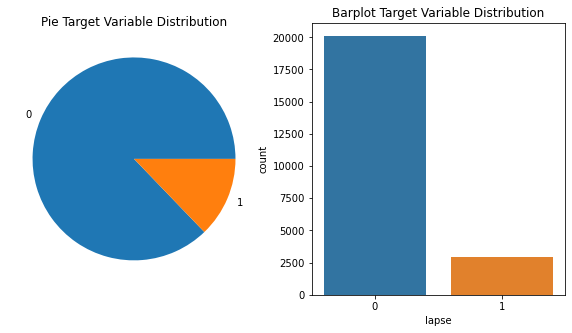

In [14]:
# Plot the target variable 
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
pieplot = df_1.groupby('lapse').count()['polholder_age'].plot(kind='pie',ax=axes[0]).set_title("Pie Target Variable Distribution")
barplot = sns.countplot(x=df_1['lapse'], data=df_1, ax=axes[1]).set_title("Barplot Target Variable Distribution")
axes[0].set_ylabel('')
plt.show()


# Numerical Features Analysis

### Analysis for numerical features (univariate analysis, bivariate analysis)

In [15]:
# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['float64','int64']]

In [16]:
# Subset with numerical features
num = X_full[numerical_cols]
num.columns

Index(['polholder_age', 'policy_age', 'policy_nbcontract', 'prem_final',
       'prem_freqperyear', 'prem_last', 'prem_market', 'prem_pure',
       'vehicl_age', 'vehicl_agepurchase'],
      dtype='object')

In [17]:
# list of numerical features
fnum = ['polholder_age', 'policy_age', 'policy_nbcontract', 'prem_final',
       'prem_freqperyear', 'prem_last', 'prem_market', 'prem_pure',
       'vehicl_age', 'vehicl_agepurchase']

In [18]:
# Univariate analysis looking at Mean, Standard Deviation, Skewness and Kurtosis
for col in num:
    print(col,
        '\nMean :', np.mean(num[col]),  
        '\nVariance :', np.var(num[col]),
        '\nStandard Deviation :', st.stdev(num[col]), 
        '\nSkewness :', stats.skew(num[col]), 
        '\nKurtosis :', stats.kurtosis(num[col]))

polholder_age 
Mean : 43.04549002601908 
Variance : 152.57247532362123 
Standard Deviation : 12.352290959026774 
Skewness : 0.8916769113608795 
Kurtosis : 0.6362468156858601
policy_age 
Mean : 2.4434518647007804 
Variance : 9.614365187839109 
Standard Deviation : 3.1007712160297944 
Skewness : 1.3274993686778152 
Kurtosis : 0.63678564183473
policy_nbcontract 
Mean : 1.3056374674761493 
Variance : 0.6219369960636644 
Standard Deviation : 0.788646922021973 
Skewness : 5.493284759088174 
Kurtosis : 54.653001293732075
prem_final 
Mean : 374.1237909800521 
Variance : 45324.092878742085 
Standard Deviation : 212.89917437453818 
Skewness : 2.2403912161091886 
Kurtosis : 9.183345219215296
prem_freqperyear 
Mean : 2.9673894189071985 
Variance : 10.067453462403218 
Standard Deviation : 3.172993863500057 
Skewness : 2.06160246707068 
Kurtosis : 3.276458047279162
prem_last 
Mean : 380.50877363399826 
Variance : 51953.41434156628 
Standard Deviation : 227.93785865026425 
Skewness : 2.24431438091972

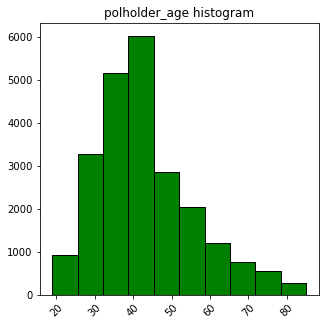

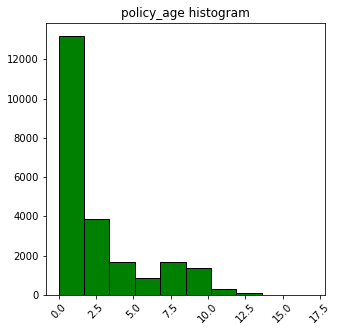

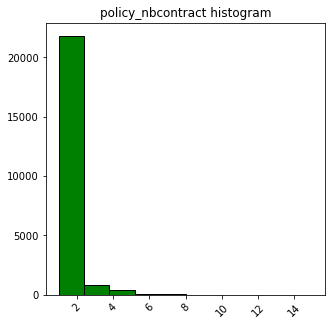

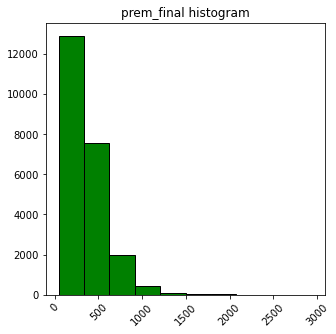

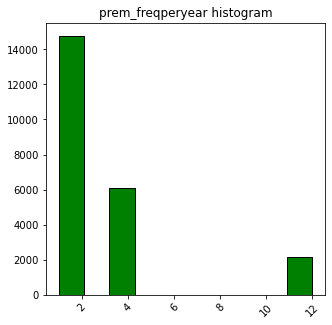

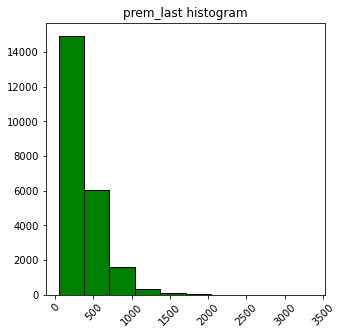

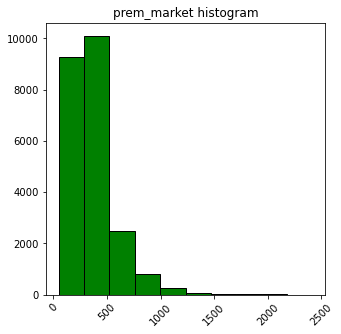

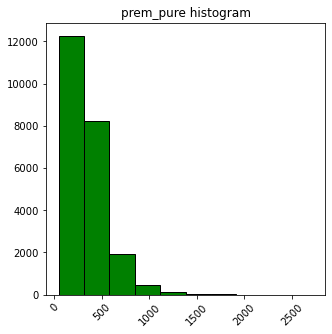

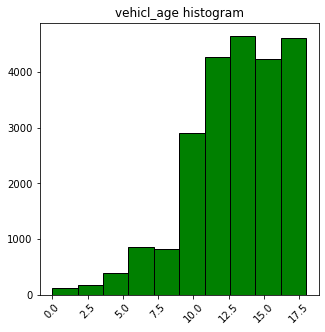

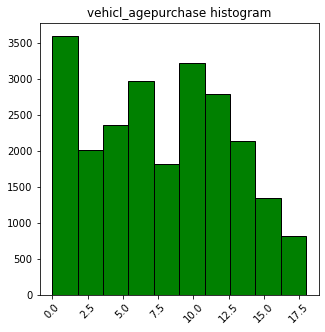

In [19]:
# Univariate analysis with histograms
for col in num:
    plt.figure(figsize=(5,5))
    x=num[col]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(col))
    plt.xticks(rotation=45)
    plt.show()

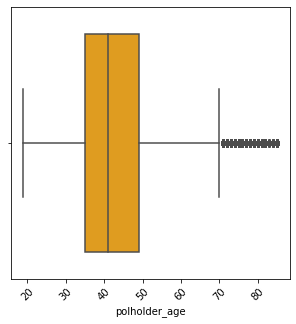

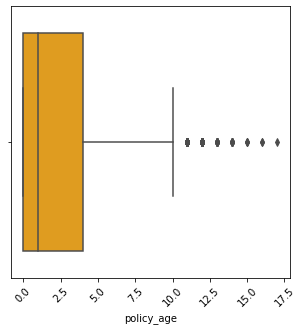

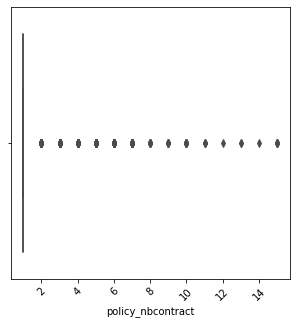

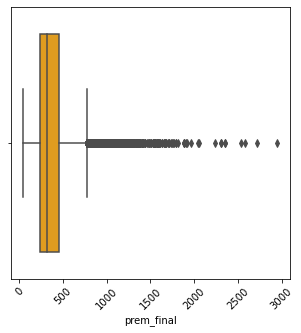

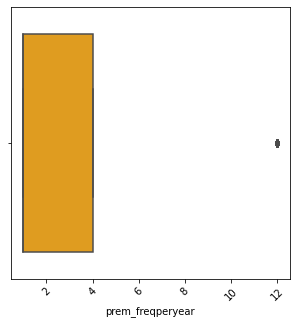

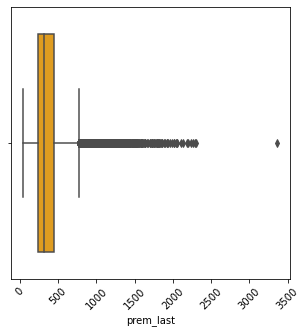

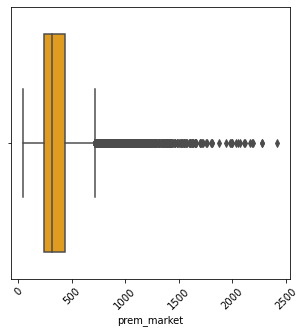

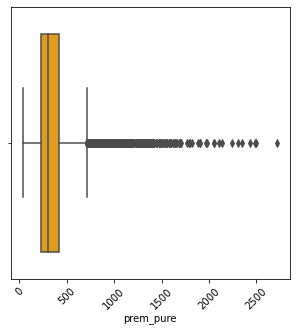

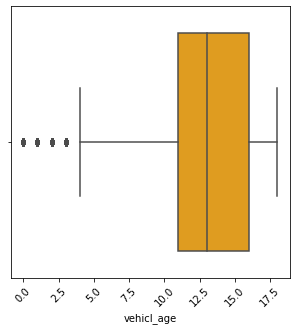

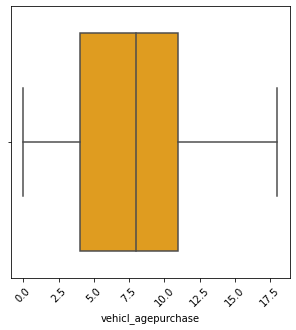

In [20]:
# Univariate analysis with box-plots
for col in num:
    plt.figure(figsize=(5,5))
    sns.boxplot(x=num[col], color="orange")
    plt.xticks(rotation=45)
    plt.show()

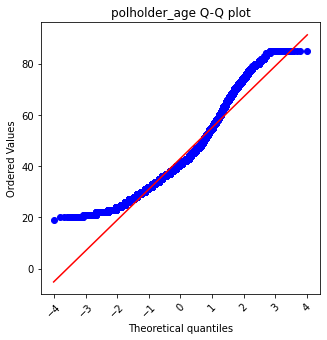

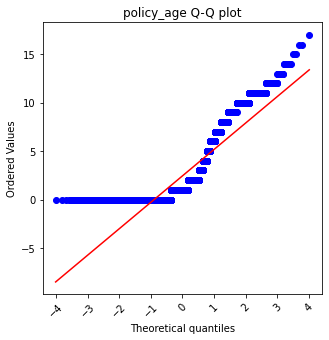

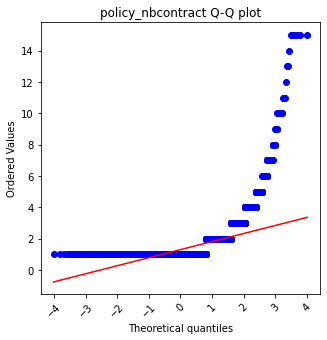

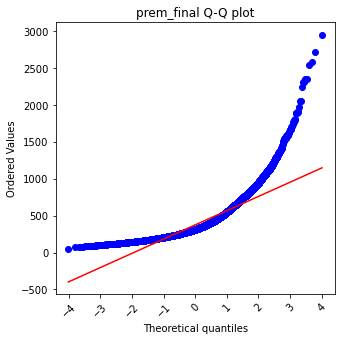

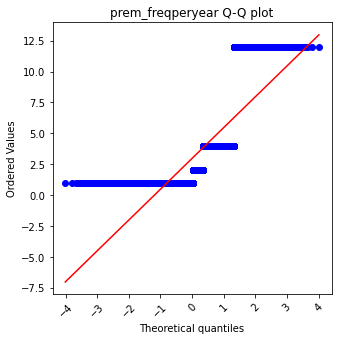

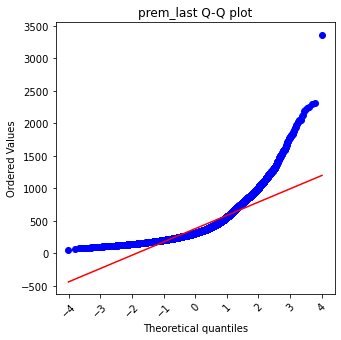

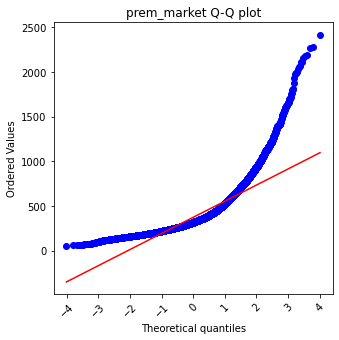

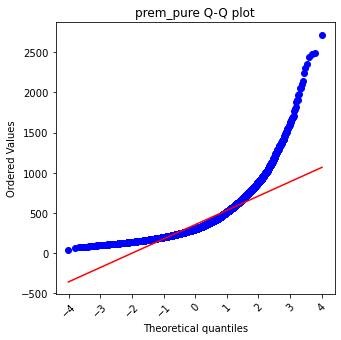

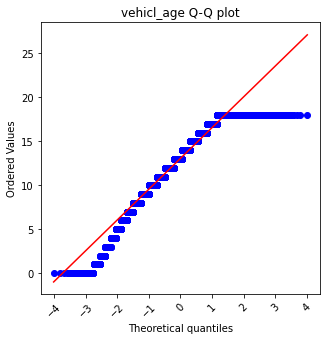

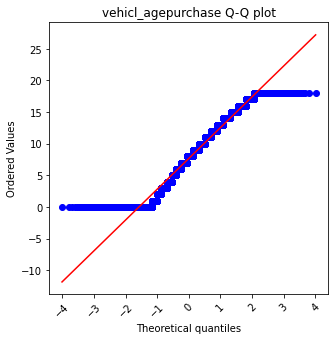

In [21]:
# Univariate analysis with Q-Q plot
for col in num:
    plt.figure(figsize=(5,5))
    res = stats.probplot(num[col], plot=plt)
    plt.title('{} Q-Q plot'.format(col))
    plt.xticks(rotation=45)
    plt.show()

In [22]:
# new subset for a bivariate analysis
num2 = pd.concat([y,num], axis=1)

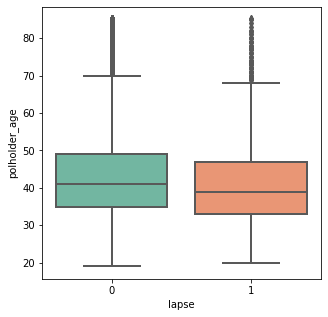

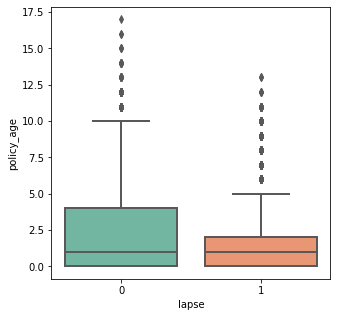

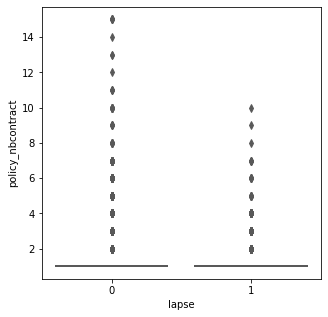

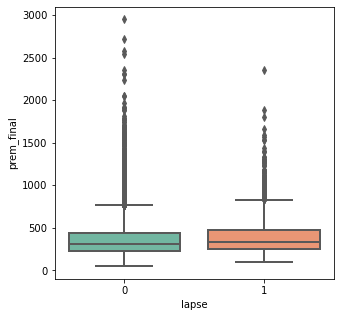

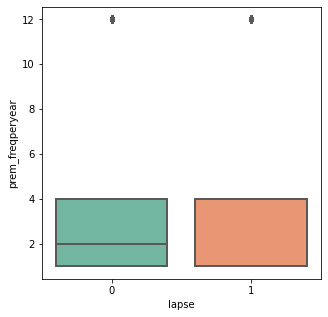

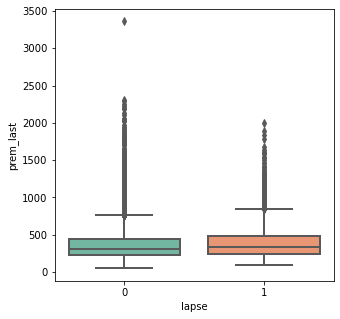

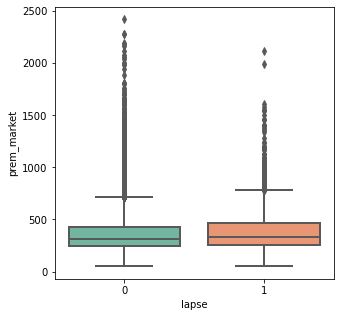

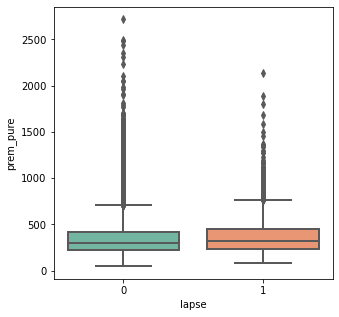

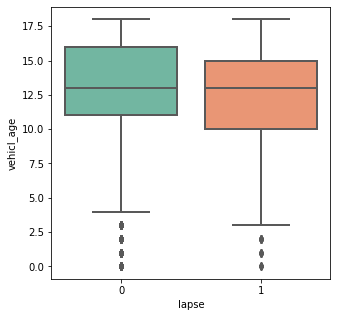

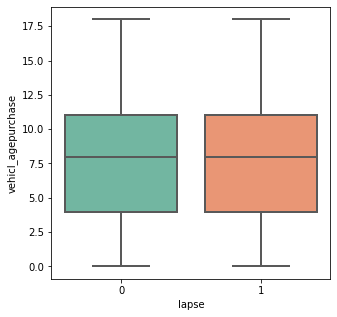

In [23]:
# Bivariate analysis with box-plots
for col in num:
    plt.figure(figsize=(5,5))
    sns.boxplot(y=col, x=y, data=num2, linewidth=2, palette="Set2")
    plt.show()

In [26]:
# Anova Test
def select_features(X, y):
    # configure to select a subset of features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit_transform(X, y)
    return fs

# feature selection
fs = select_features(num, y)
pvalues = pd.DataFrame(fs.pvalues_, columns = ['pvalue'])
pvalues.index = num.columns
pvalues

,pvalue
polholder_age,4.627428e-22
policy_age,5.425416e-21
policy_nbcontract,3.571800e-01
prem_final,4.924935e-09
prem_freqperyear,2.173495e-05
prem_last,1.323984e-09
prem_market,1.036711e-05
prem_pure,2.076163e-06
vehicl_age,3.479189e-14
vehicl_agepurchase,1.569897e-01


# Categorical Features Analysis

### Analysis for categorical features (univariate analysis, bivariate analysis)

In [27]:
# let's have a look at how many labels for categorical features
for col in X_full.columns:
    if X_full[col].dtype =="object":
        print(col, ': ', len(X_full[col].unique()), ' labels')

polholder_BMCevol :  3  labels
polholder_diffdriver :  7  labels
polholder_gender :  2  labels
polholder_job :  2  labels
policy_caruse :  3  labels
vehicl_garage :  8  labels
vehicl_powerkw :  11  labels
vehicl_region :  14  labels


In [28]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() <= 15 and 
                    X_full[cname].dtype == "object"]

In [29]:
# Subset with categorical features
cat = X_full[categorical_cols]
cat.columns


Index(['polholder_BMCevol', 'polholder_diffdriver', 'polholder_gender',
       'polholder_job', 'policy_caruse', 'vehicl_garage', 'vehicl_powerkw',
       'vehicl_region'],
      dtype='object')

In [30]:
# List of categorical features
fcat = ['polholder_BMCevol', 'polholder_diffdriver', 'polholder_gender',
       'polholder_job', 'policy_caruse', 'vehicl_garage', 'vehicl_powerkw',
       'vehicl_region']

In [31]:
# Univariate analysis looking at frequency
for col in cat:
    count = pd.crosstab(index = cat[col], columns="count")
    percentage = pd.crosstab(index = cat[col], columns="frequency")/pd.crosstab(index = cat[col], columns="frequency").sum()
    tab = pd.concat([count, percentage], axis=1)
    print('\n',tab)


 col_0              count  frequency
polholder_BMCevol                  
down               10155   0.440373
stable             12036   0.521943
up                   869   0.037684

 col_0                 count  frequency
polholder_diffdriver                  
all drivers > 24       1728   0.074935
commercial               40   0.001735
learner 17               42   0.001821
only partner           8128   0.352472
same                  11155   0.483738
unknown                  12   0.000520
young drivers          1955   0.084779

 col_0             count  frequency
polholder_gender                  
Female             8339   0.361622
Male              14721   0.638378

 col_0          count  frequency
polholder_job                  
medical         9482   0.411188
normal         13578   0.588812

 col_0                      count  frequency
policy_caruse                              
commercial                    10   0.000434
private or freelance work  19567   0.848526
unknown        

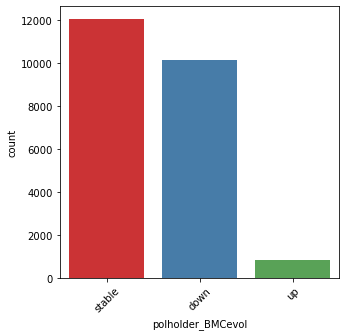

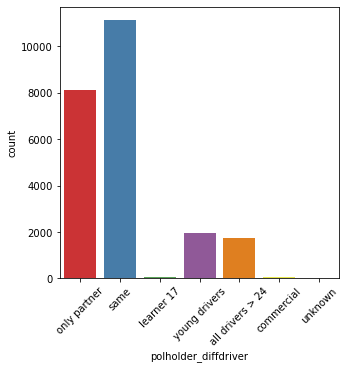

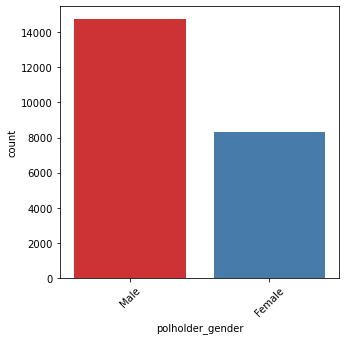

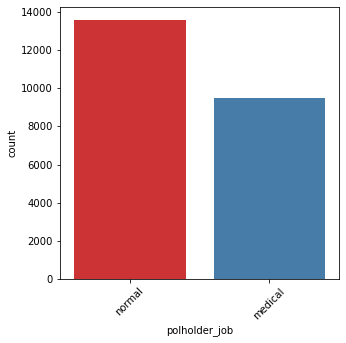

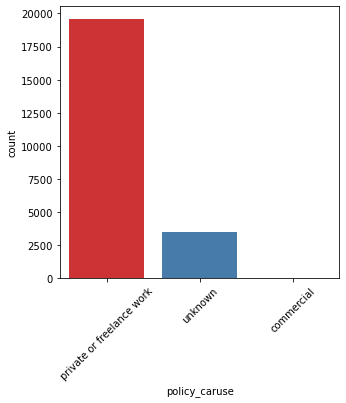

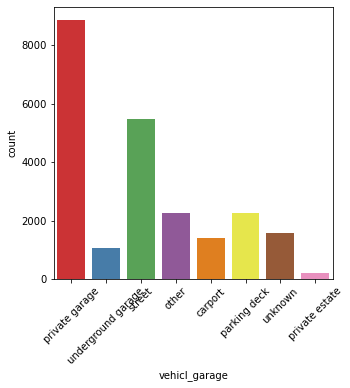

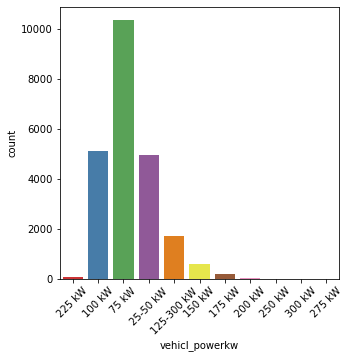

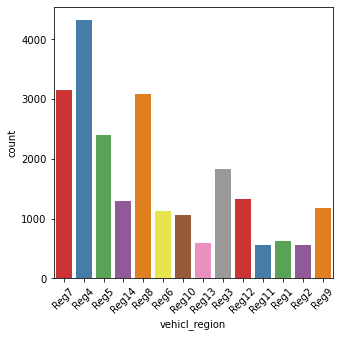

In [32]:
# Univariate analysis with barplots
for col in cat:
    plt.figure(figsize=(5,5))
    sns.countplot(x=cat[col], data=cat, palette="Set1")
    plt.xticks(rotation=45)
    plt.show()

In [33]:
# new subset for a bivariate analysis
cat2 = pd.concat([y,cat], axis=1)

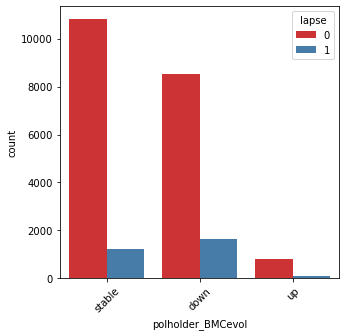

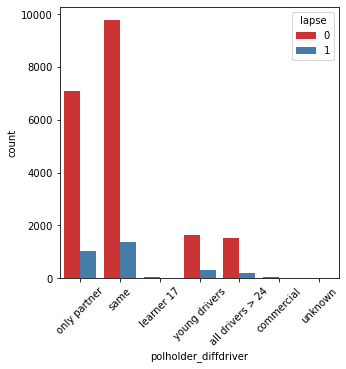

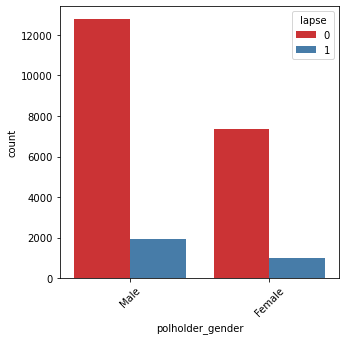

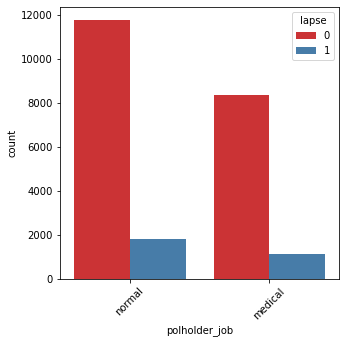

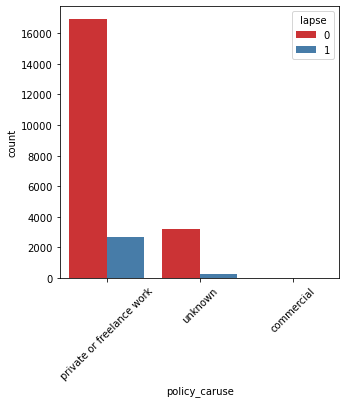

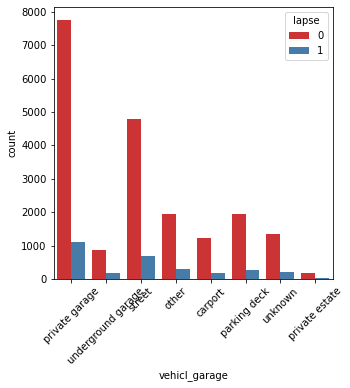

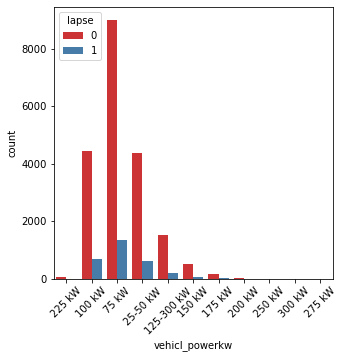

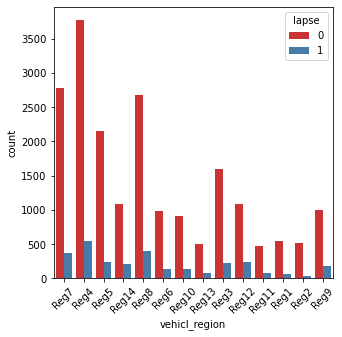

In [34]:
# bivariate analysis with barplot
for col in cat:
    plt.figure(figsize=(5,5))
    sns.countplot(x=cat[col], hue=y, data=cat, palette="Set1")
    plt.xticks(rotation=45)
    plt.show()

In [35]:
# Function for query and barplot about lapse per each class of variable
def query(data,col):
    # groupby
    df = data.groupby(data[col], as_index=False)['lapse'].sum()
    df['PERCENTAGE'] = df['lapse']/df['lapse'].sum()*100
    # dropping not matching rows
    df = df.dropna()
    # ranking 
    df = df.sort_values(by = 'lapse', ascending = False).reset_index(drop=True)
    df_q = df.style.background_gradient(cmap='winter').format({'PERCENTAGE': "{:.2f}"}).format({'lapse':"{:,.2f}"})
    # barplot
    index=list(df.columns[0:1])
    barplot = df[df.columns[0:2]].sort_values(by = "lapse", ascending = True).set_index(index).plot.barh()
    plt.xticks(rotation=0)
    plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
    return df_q
    plt.show()
    return barplot
    plt.show()

lapse per polholder_BMCevol


,polholder_BMCevol,lapse,PERCENTAGE
0,down,"1,638.00",55.45
1,stable,"1,231.00",41.67
2,up,85.00,2.88


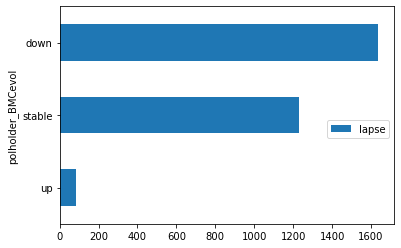

In [36]:
# query and barplot
variable = 'polholder_BMCevol'
print('lapse per {}'.format(variable))
query(cat2, col='polholder_BMCevol')

lapse per polholder_diffdriver


,polholder_diffdriver,lapse,PERCENTAGE
0,same,"1,367.00",46.28
1,only partner,"1,043.00",35.31
2,young drivers,327.00,11.07
3,all drivers > 24,205.00,6.94
4,learner 17,8.00,0.27
5,commercial,2.00,0.07
6,unknown,2.00,0.07


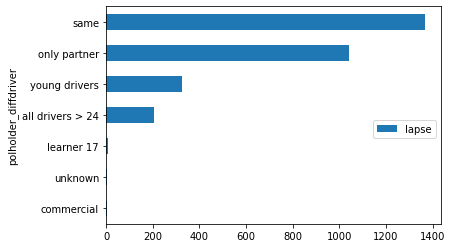

In [37]:
# query and barplot
variable = 'polholder_diffdriver'
print('lapse per {}'.format(variable))
query(cat2, col='polholder_diffdriver')

Lapse per polholder_gender


,polholder_gender,lapse,PERCENTAGE
0,Male,"1,957.00",66.25
1,Female,997.00,33.75


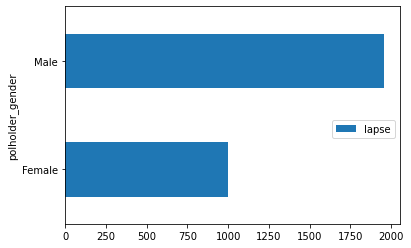

In [38]:
# query and barplot
variable = 'polholder_gender'
print('Lapse per {}'.format(variable))
query(cat2, col='polholder_gender')

Lapse per polholder_job


,polholder_job,lapse,PERCENTAGE
0,normal,"1,810.00",61.27
1,medical,"1,144.00",38.73


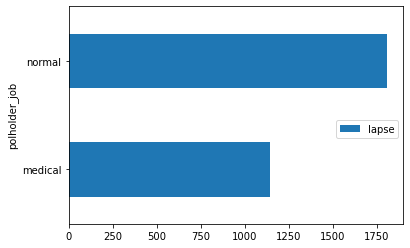

In [39]:
# query and barplot
variable = 'polholder_job'
print('Lapse per {}'.format(variable))
query(cat2, col='polholder_job')

Lapse per policy_caruse


,policy_caruse,lapse,PERCENTAGE
0,private or freelance work,"2,661.00",90.08
1,unknown,291.00,9.85
2,commercial,2.00,0.07


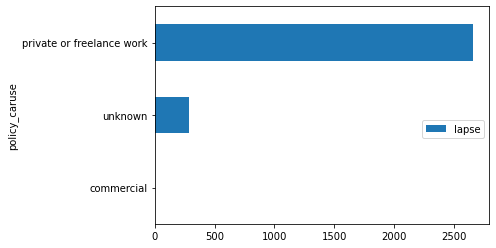

In [40]:
# query and barplot
variable = 'policy_caruse'
print('Lapse per {}'.format(variable))
query(cat2, col='policy_caruse')

Lapse per vehicl_garage


,vehicl_garage,lapse,PERCENTAGE
0,private garage,"1,107.00",37.47
1,street,676.00,22.88
2,other,286.00,9.68
3,parking deck,284.00,9.61
4,unknown,217.00,7.35
5,carport,193.00,6.53
6,underground garage,175.00,5.92
7,private estate,16.00,0.54


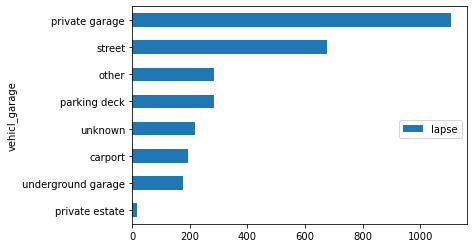

In [41]:
# query and barplot
variable = 'vehicl_garage'
print('Lapse per {}'.format(variable))
query(cat2, col='vehicl_garage')

Lapse per vehicl_powerkw


,vehicl_powerkw,lapse,PERCENTAGE
0,75 kW,"1,350.00",45.70
1,100 kW,682.00,23.09
2,25-50 kW,610.00,20.65
3,125-300 kW,205.00,6.94
4,150 kW,70.00,2.37
5,175 kW,25.00,0.85
6,225 kW,8.00,0.27
7,200 kW,2.00,0.07
8,250 kW,2.00,0.07
9,275 kW,0.00,0.00


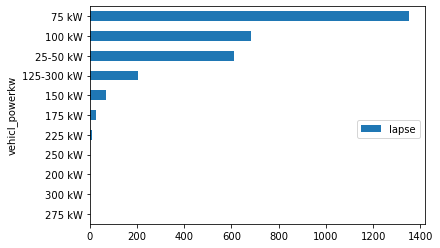

In [42]:
# query and barplot
variable = 'vehicl_powerkw'
print('Lapse per {}'.format(variable))
query(cat2, col='vehicl_powerkw')

Lapse per vehicl_region


,vehicl_region,lapse,PERCENTAGE
0,Reg4,548.00,18.55
1,Reg8,399.00,13.51
2,Reg7,374.00,12.66
3,Reg5,240.00,8.12
4,Reg12,239.00,8.09
5,Reg3,223.00,7.55
6,Reg14,204.00,6.91
7,Reg9,175.00,5.92
8,Reg10,139.00,4.71
9,Reg6,135.00,4.57


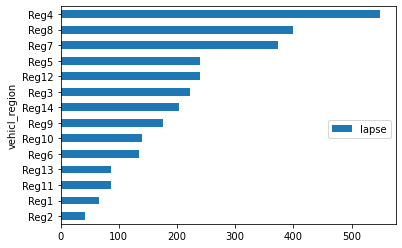

In [43]:
# query and barplot
variable = 'vehicl_region'
print('Lapse per {}'.format(variable))
query(cat2, col='vehicl_region')

In [63]:
# Chi-Square Test
alpha = 0.05
selection = []
for var in cat:
    X = cat2[var].astype(str)
    Y = cat2['lapse'].astype(str)
    dfObserved = pd.crosstab(Y,X)
    p = stats.chi2_contingency(dfObserved.values)[1]
    selection.append(p)
    features = np.asarray(selection)
    pvalues = pd.DataFrame(features, columns = ['pvalue'])
pvalues.index = cat.columns
pvalues

,pvalue
polholder_BMCevol,1.214243e-39
polholder_diffdriver,4.076257e-06
polholder_gender,3.723144e-03
polholder_job,4.966704e-03
policy_caruse,1.225633e-16
vehicl_garage,3.085934e-03
vehicl_powerkw,7.086512e-01
vehicl_region,1.037137e-13
